In [1]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from PIL import Image, ImageChops
from tqdm import tqdm
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import utils
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152
from torch import nn
from pytorch_lightning import Trainer
from torchvision.transforms.functional import pad
from torch.utils.data import random_split
from lightning.pytorch import loggers as pl_loggers
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from pytorch_lightning.callbacks import EarlyStopping


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
import sys
import os
import shutil
REPO_URL = "https://github.com/roihezkiyahu/mga.git"
DEST_DIR = "mga"  # Name of the directory the repo will be cloned into

# Check if directory already exists
if os.path.exists(DEST_DIR):
    print(f"Directory {DEST_DIR} already exists. Removing...")
    shutil.rmtree(DEST_DIR)

# Clone the repository
!git clone {REPO_URL} {DEST_DIR}

sys.path.append('/kaggle/working/mga')

Cloning into 'mga'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 140 (delta 26), reused 55 (delta 20), pack-reused 75
Receiving objects: 100% (140/140), 75.80 MiB | 7.57 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [4]:
from mga.utils.util_funcs import create_dataframe, create_bounding_boxes, sort_yolo_folders, load_bounding_boxes, annotation_to_labels, create_gen_df
from plot_functions.mga_plt import plot_metrics_from_version, show_images_in_grid,compute_and_plot_confusion_matrix
from mga.data.global_data import outlier_images
from mga.models.mga_classifier import ChartDataLoader,resize_and_pad, invert_img, get_transforms, GraphClassifier, evaluate_model

In [5]:
tr_img = '/kaggle/input/mga-data/train/images'
tr_an  = '/kaggle/input/mga-data/train/annotations'
gen_folder = "/kaggle/input/gen-charts/gen_charts"
# te_img = '/kaggle/input/benetech-making-graphs-accessible/test/images'

In [6]:
train_df = pd.read_csv("/kaggle/input/bebetechmga/train_df.csv")

In [7]:
train_df["annotation"] = train_df["annotation"].apply(lambda x: x.replace("benetech-making-graphs-accessible/train", "mga-data/train"))
train_df["image"] = train_df["image"].apply(lambda x: x.replace("benetech-making-graphs-accessible/train", "mga-data/train"))

In [8]:
train_df = train_df[~train_df["name"].isin(outlier_images)].reset_index(drop = True)

In [9]:
gen_df = create_gen_df(gen_folder)

In [10]:
gen_df["chart-type"].value_counts()

horizontal_bar    986
line              827
dot               590
scatter           196
Name: chart-type, dtype: int64

# config

In [11]:
batch_size = 16
validation_ratio = 0.2
image_size = 256
learning_rate = 5e-5
train_model = True
gray_scale=False
model_weights_path = "mga/weights/classifier/resnet_34_999.pth"

In [12]:
n_obs = len(train_df)
train_size = int((1-validation_ratio) * n_obs)
val_size = n_obs - train_size
acc_device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(acc_device)

# DataLoaders

In [13]:
transform_train, transform_val = get_transforms(image_size, gray_scale=gray_scale)

In [14]:
# dataset = ChartDataLoader(train_df, transform=transform_train)

In [15]:
# Splitting the original dataframe into training and validation dataframes
train_df_split, val_df_split = train_test_split(train_df, test_size=(val_size / (train_size + val_size)))

train_df_split = pd.concat([train_df_split, gen_df])

# Using the split dataframes to initialize the ChartDataLoader instances
train_dataset = ChartDataLoader(train_df_split.reset_index(drop=True), transform=transform_train)
val_dataset = ChartDataLoader(val_df_split.reset_index(drop=True), transform=transform_val)

# DataLoaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())


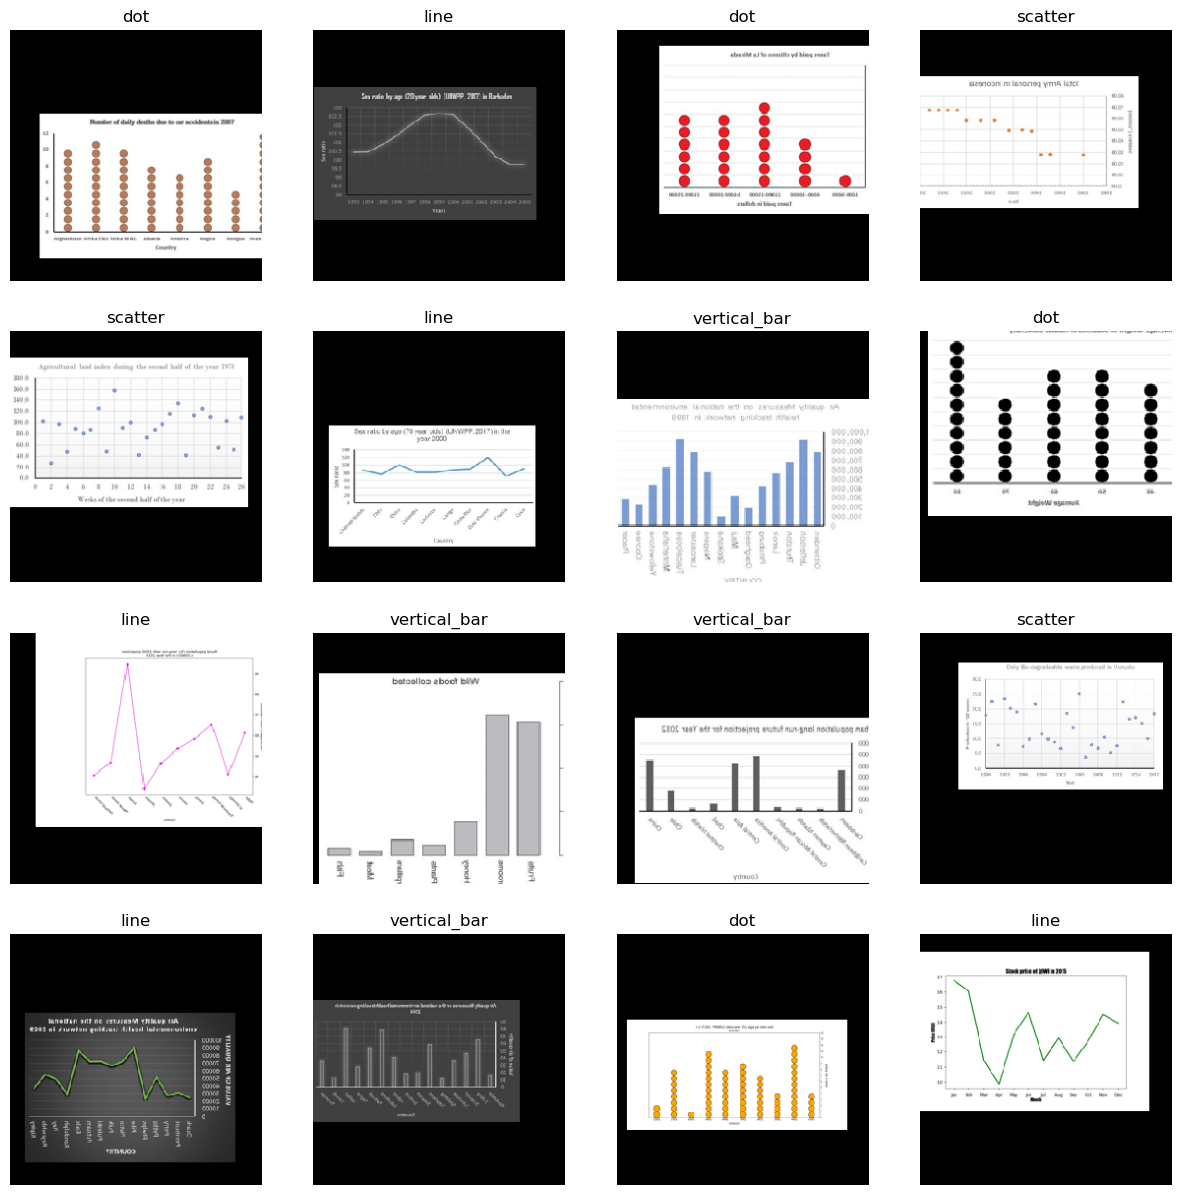

In [16]:
show_images_in_grid(train_dataloader, 4, 4)

In [17]:
train_df["chart-type"].value_counts()

line              24741
vertical_bar      19189
scatter           11240
dot                5131
horizontal_bar       73
Name: chart-type, dtype: int64

# Classifier

In [ ]:
if train_model:
    model = GraphClassifier(num_classes=5, lr=learning_rate, one_channel=gray_scale)

    gpus = 1 if torch.cuda.is_available() else None

    tb_logger = pl_loggers.TensorBoardLogger(save_dir="logs/")
    csv_logger = pl_loggers.CSVLogger(save_dir="logs/csv")
    
    early_stop_callback = EarlyStopping(
       monitor='val_acc',
       min_delta=0.00,
       patience=5,
       verbose=True,
       mode='max'
    )

    trainer = Trainer(max_epochs=50, accelerator=acc_device, logger=[tb_logger, csv_logger],
                     callbacks=[early_stop_callback])
    trainer.fit(model, train_dataloader, val_dataloader)

    plot_metrics_from_version(0, base_path="/kaggle/working/logs/csv/lightning_logs/")

    torch.save(model.state_dict(), 'model_weights.pth')
else:
    model = GraphClassifier(num_classes=5, lr=learning_rate, one_channel=gray_scale)
    model.load_state_dict(torch.load(model_weights_path))

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
model.to(acc_device)
val_dataset = ChartDataLoader(val_df_split.reset_index(drop=True), transform=transform_val, with_name=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

all_preds, all_labels = evaluate_model(model, val_dataloader, acc_device, with_name=True)
compute_and_plot_confusion_matrix(all_labels, all_preds)

In [ ]:
train_dataset_no_aug = ChartDataLoader(train_df_split.reset_index(drop=True), transform=transform_val, with_name=True)

train_dataloader_no_aug = torch.utils.data.DataLoader(train_dataset_no_aug, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())

model.to(acc_device)
all_preds, all_labels = evaluate_model(model, train_dataloader_no_aug, acc_device, with_name=True)
compute_and_plot_confusion_matrix(all_labels, all_preds)

In [ ]:
gen_dataset = ChartDataLoader(gen_df.reset_index(drop=True), transform=transform_val, with_name=True)

gen_dataloader = torch.utils.data.DataLoader(gen_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())

model.to(acc_device)
all_preds, all_labels = evaluate_model(model, gen_dataloader, acc_device, with_name=True)
compute_and_plot_confusion_matrix(all_labels, all_preds)